In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings("ignore")
from keras import utils


In [ ]:
paths =[]
labels = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/toronto/TESS Toronto emotional speech set data'):
  for filename in filenames:
      paths.append(os.path.join(dirname, filename))
      label = filename.split("_")[-1]
      label = label.split('.')[0]
      labels.append(label.lower())
  if len(paths) ==2800:
      break
print('Dataset is loaded')

Dataset is loaded


In [ ]:

df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
1,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
2,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
3,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
4,/content/drive/MyDrive/toronto/TESS Toronto em...,ps


In [ ]:
df = df[df['label'] != 'ps (1)']


In [ ]:

df['label'].value_counts()

,count
label,
ps,800
angry,800
happy,800
sad,800
fear,800
neutral,800
disgust,800


In [ ]:

df['label_count']= df['label'].value_counts()
df.drop('label_count', axis = 1)

,speech,label
0,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
1,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
2,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
3,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
4,/content/drive/MyDrive/toronto/TESS Toronto em...,ps
...,...,...
5596,/content/drive/MyDrive/toronto/TESS Toronto em...,happy
5597,/content/drive/MyDrive/toronto/TESS Toronto em...,happy
5598,/content/drive/MyDrive/toronto/TESS Toronto em...,happy
5599,/content/drive/MyDrive/toronto/TESS Toronto em...,happy


In [ ]:
df.info

<bound method DataFrame.info of                                                  speech  label  label_count
0     /content/drive/MyDrive/toronto/TESS Toronto em...     ps          NaN
1     /content/drive/MyDrive/toronto/TESS Toronto em...     ps          NaN
2     /content/drive/MyDrive/toronto/TESS Toronto em...     ps          NaN
3     /content/drive/MyDrive/toronto/TESS Toronto em...     ps          NaN
4     /content/drive/MyDrive/toronto/TESS Toronto em...     ps          NaN
...                                                 ...    ...          ...
5596  /content/drive/MyDrive/toronto/TESS Toronto em...  happy          NaN
5597  /content/drive/MyDrive/toronto/TESS Toronto em...  happy          NaN
5598  /content/drive/MyDrive/toronto/TESS Toronto em...  happy          NaN
5599  /content/drive/MyDrive/toronto/TESS Toronto em...  happy          NaN
5600  /content/drive/MyDrive/toronto/TESS Toronto em...  happy          NaN

[5600 rows x 3 columns]>

<Axes: xlabel='label', ylabel='count'>

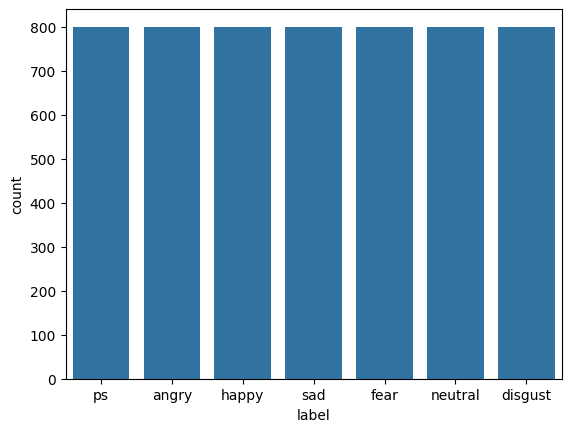

In [ ]:
sns.countplot(data=df, x='label')

In [ ]:

def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz' )
    plt.colorbar()

In [ ]:
#df.drop('label_count', axis=1, inplace=True)
print(df.head())
print(df['label'].unique())

                                              speech label  label_count
0  /content/drive/MyDrive/toronto/TESS Toronto em...    ps          NaN
1  /content/drive/MyDrive/toronto/TESS Toronto em...    ps          NaN
2  /content/drive/MyDrive/toronto/TESS Toronto em...    ps          NaN
3  /content/drive/MyDrive/toronto/TESS Toronto em...    ps          NaN
4  /content/drive/MyDrive/toronto/TESS Toronto em...    ps          NaN
['ps' 'angry' 'happy' 'sad' 'fear' 'neutral' 'disgust']


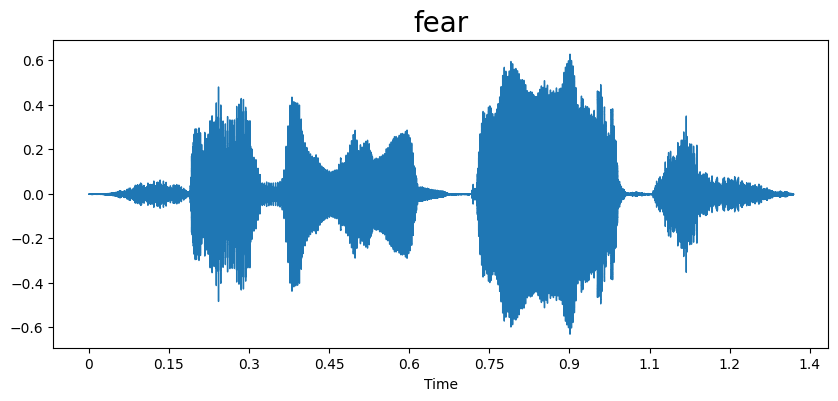

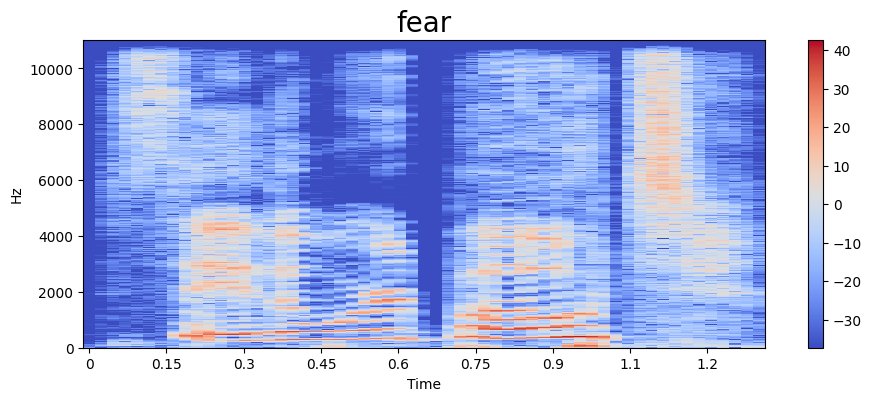

In [ ]:
emotion = 'fear'
path = np.array(df['speech'][df['label'] ==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

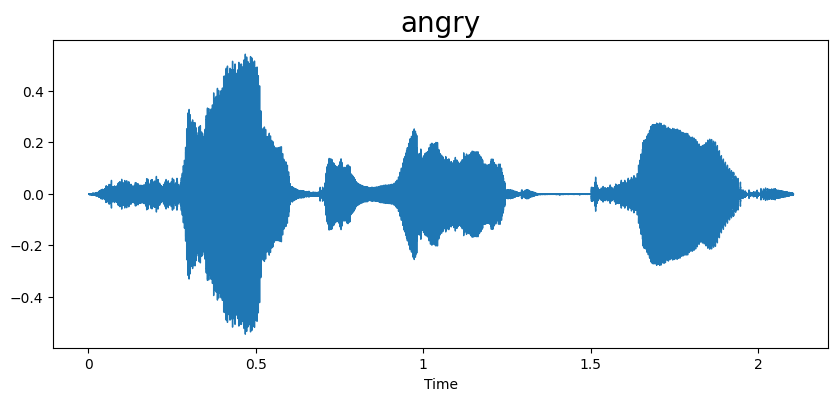

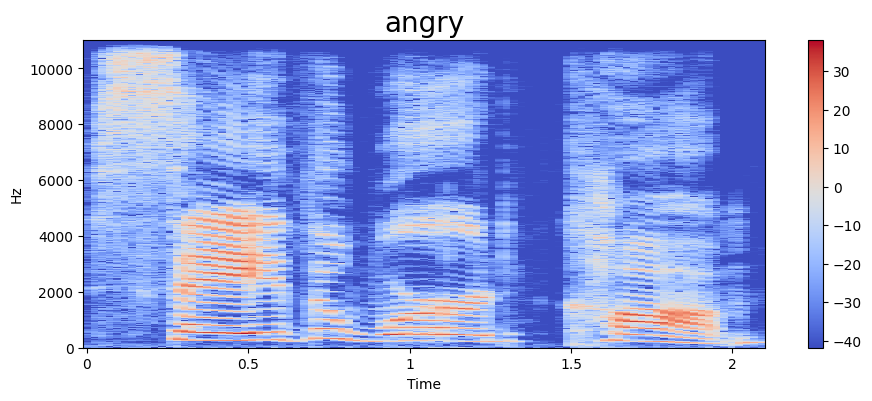

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

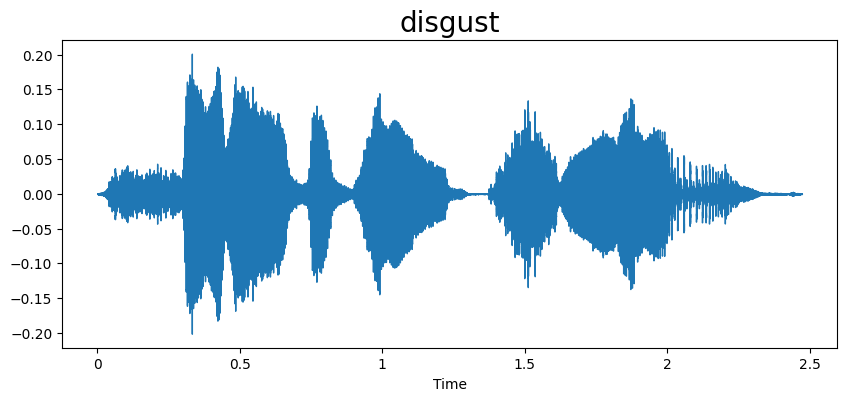

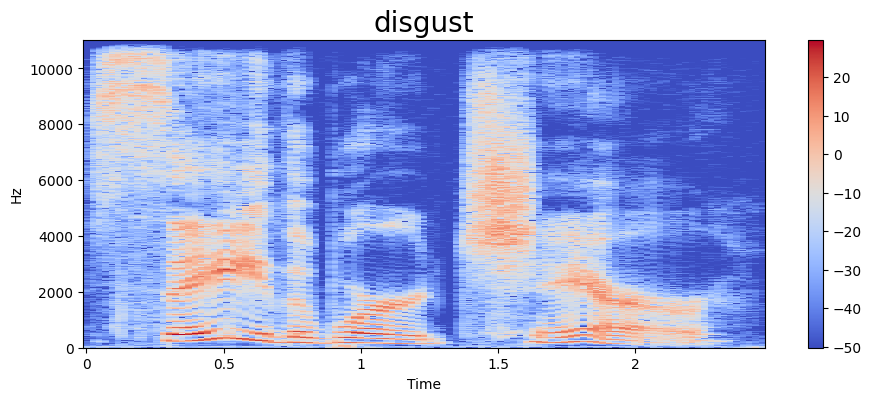

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def extract_features(filename):
    y, sr = librosa.load(filename, duration=2.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T, axis=0)

    pitches, magnitudes, *_ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    pitch_values = pitches[np.where(~np.isnan(pitches))]
    pitch_mean = np.mean(pitch_values) if len(pitch_values) > 0 else 0
    pitch_std = np.std(pitch_values) if len(pitch_values) > 0 else 0

    energy = np.sum(y ** 2) / len(y)

    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

    spectrum = np.fft.rfft(y)
    freqs = np.fft.rfftfreq(len(y), 1 / sr)
    formant_freqs = freqs[np.argsort(np.abs(spectrum))[-5:]]

    speech_rate = zero_crossing_rate * sr

    features = np.hstack((mfcc, pitch_mean, pitch_std, energy, zero_crossing_rate, formant_freqs[:3], speech_rate))

    return features


In [ ]:
features = []
labels = []

for i, row in df.iterrows():
    audio_file = row['speech']
    emotion_label = row['label']

    if os.path.exists(audio_file):
        feature = extract_features(audio_file)
        features.append(feature)
        labels.append(emotion_label)

features = np.array(features)
labels = np.array(labels)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM (256, return_sequences=False, input_shape=(30,1)), Dropout(0.5),
    Dense(128, activation='relu'), Dropout(0.5),
    Dense(64, activation= 'relu'), Dropout(0.5),
    Dense(7, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model. summary()
Model: "sequential"

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=30, batch_size=64)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.1590 - loss: 2.1201 - val_accuracy: 0.2768 - val_loss: 1.6347
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.2886 - loss: 1.6592 - val_accuracy: 0.5616 - val_loss: 1.2251
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.3874 - loss: 1.3837 - val_accuracy: 0.6009 - val_loss: 1.0292
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.4813 - loss: 1.1593 - val_accuracy: 0.7509 - val_loss: 0.6961
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.6260 - loss: 0.8936 - val_accuracy: 0.7786 - val_loss: 0.5287
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.7234 - loss: 0.6976 - val_accuracy: 0.8098 - val_loss: 0.3533
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7741 - loss: 0.5678 - val_accuracy: 0.8152 - val_loss: 0.3310
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.7988 - loss: 0.4856 - val_accuracy:

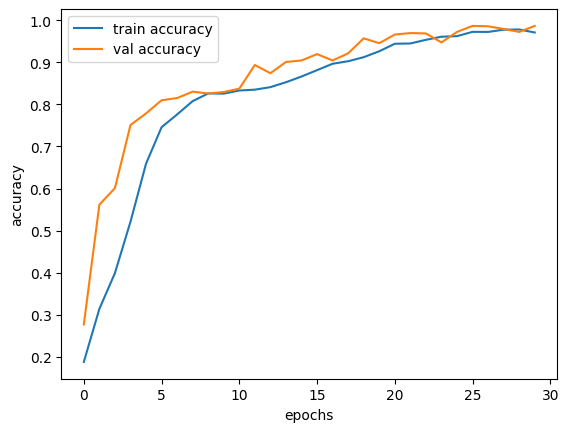

In [ ]:
epochs=list(range(30))
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

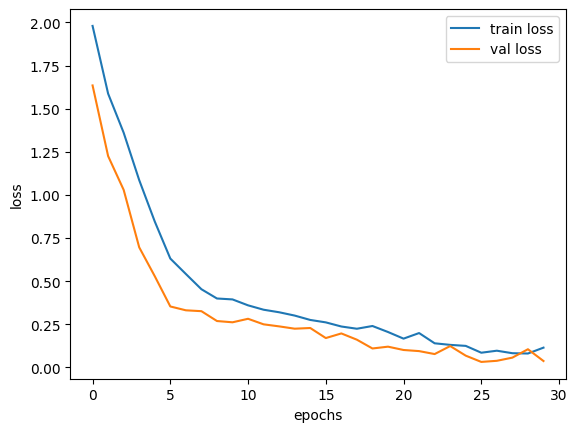

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs, loss, label= 'train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt. legend()
plt.show()